In [1]:
from matplotlib import rc

from pathlib import Path
import numpy as np
import os
import xarray as xr
from dask.distributed import Client
import dask.array as da
from collections import OrderedDict               # We often use this to organise our experiments
import haversine
import matplotlib.pyplot as plt
from pathlib import Path
os.chdir("/home/149/ab8992/tasman-tides/")
import ttidelib as tt
from importlib import reload
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41017,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:38845,Total threads: 4
Dashboard: /proxy/46433/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34625,


# Draft the postprocessing function

I've got a test set of outputs to use to turn into permanent outputs on gdata

Filestructure:

gdata / tasman-tides / experiment / output00x / postprocessed files

In [2]:
reload(tt)
expt = "fullexpt-test"

## Should read last output that exists!
output = 0


mom6out = Path.cwd() / "rundirs" / expt / f"archive/output{output:03d}"
gdataout = Path("/g/data/nm03/ab8992/") / expt / f"output{output:03d}"
if not gdataout.exists():
    gdataout.mkdir(parents=True)

diags = {
    "hourly_rho":{"x":"xh","y":"yh","z":"zl"},
    "hourly_u":{"x":"xq","y":"yh","z":"zl"},
    "hourly_v":{"x":"xh","y":"yq","z":"zl"},
    "hourly_e":{"x":"xh","y":"yh","z":"zi"}
}


for diag in diags:
    print(diag)
    ds = xr.open_mfdataset(
        str(mom6out / f"*{diag}.nc"),
        chunks={diags[diag]["z"]: 10,"time":50},
        decode_times=False,
    )

    out = tt.beamgrid(ds,xname = diags[diag]["x"],yname = diags[diag]["y"])

    out = out.chunk({"yb": 10}).persist()

    ## Now split the data up into different y levels
    ## Try split in 4 parts in yh direction

    i = 0
    while i * 10 < out["yb"].shape[0]:
        out.isel(
            {
                "yb" : slice(i*10,(i+1)*10)
                }
                ).to_netcdf(gdataout / f"y{i:02d}_{diag}.nc")


        i += 1
    



4.0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('lat', 'lon') from data variable rhopot2 as the horizontal dimensions for the regridding.
  warnings.warn(


AttributeError: 'Dataset' object has no attribute 'xh'

In [ ]:
exptdir = Path("/home/")

In [4]:
out.isel(
            {
                diags[diag]["z"] : slice(i*10,(i+1)*10)
                }
                )

<xarray.Dataset>
Dimensions:  (time: 240, zl: 0, yb: 101, xb: 376)
Coordinates:
  * zl       (zl) float64 
  * time     (time) float64 2.126e+05 2.126e+05 ... 2.129e+05 2.129e+05
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
    lat      (yb, xb) float64 -44.41 -44.42 -44.44 ... -46.45 -46.47 -46.48
    lon      (yb, xb) float64 144.7 144.7 144.8 144.8 ... 165.5 165.6 165.6
Data variables:
    rhopot2  (time, zl, yb, xb) float32 dask.array<chunksize=(50, 0, 101, 376), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          eac
    grid_type:      regular
    grid_tile:      N/A
    Description:    Beamwidth 400km, Beamlength 1500km, Resolution 4.0km, ang...

In [13]:
loaded = xr.open_mfdataset("/g/data/nm03/ab8992/fullexpt-test/output000/*")
loaded

<xarray.Dataset>
Dimensions:  (time: 240, zl: 100, yb: 101, xb: 376)
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.696e+03
  * time     (time) object 2015-04-11 01:00:00 ... 2015-04-21 00:00:00
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
    lat      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
    lon      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
Data variables:
    rhopot2  (time, zl, yb, xb) float32 dask.array<chunksize=(240, 10, 101, 376), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          eac
    grid_type:      regular
    grid_tile:      N/A
    Description:    Beamwidth 400km, Beamlength 1500km, Resolution 4.0km, ang...

In [10]:
loaded = xr.open_mfdataset("/g/data/nm03/ab8992/fullexpt-test/output000/*",combine = "nested",concat_dim=diags[diag]["z"])

loaded

ValueError: 'lat' not present in all datasets and coords='different'. Either add 'lat' to datasets where it is missing or specify coords='minimal'.

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import ttidelib as tt

## Callum's method

Text(0.5, 1.0, 'Subgrid in latlon')

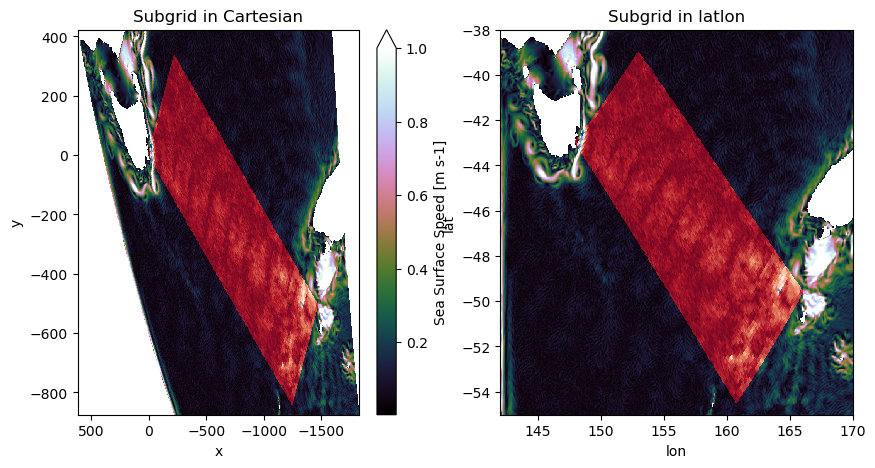

In [182]:
u = xr.open_dataset(path / "20150501.ocean_hourly.nc" ,chunks = "auto").speed.sel(xh = slice(None,170),yh = slice(-55,-38)).isel(time = 5).load()

# lat0,lon0 = -41,148
lon = (u.xh.data)
lat = u.yh.data 

LAT , LON = np.meshgrid(lat,lon)

lat0,lon0 = -43,148

beamwidth_km = 400
beamlength_km = 1500

## Define the original grid on cartesian coordinates
x0,y0 = 6371 * np.cos(lat0 * np.pi/180) * np.sin(lon0 * np.pi/180) , 6371 * np.sin(lat0 * np.pi/180)
# x0,y0 = 0 , R * np.sin(lat0)
# x,y = R * np.cos(LAT) * np.sin(LON), R * np.sin(LAT) - y0
x,y = lonlat_to_xy(LON,LAT,lon0,lat0)

## Define target grid on rotated mesh in km
y_,x_ = np.linspace(0,beamlength_km,100),np.linspace(0,beamwidth_km,100)
X_,Y_ = np.meshgrid(x_,y_)
## Define the rotated grid as represented on the original grid. I.E, the points on x_ y_ as represented on the x,y coordinate system
theta_ = theta * np.pi/180
Xrot , Yrot = X_ * np.cos(theta_) - Y_ * np.sin(theta_) , X_ * np.sin(theta_) + Y_ * np.cos(theta_)

## Calculate X,Y (the rotated grid points) as lat/lon
LONrot,LATrot = xy_to_lonlat(Xrot,Yrot,x0,y0)
# LONrot = 180 - LONrot


u = u.assign_coords(
    {"x":(["xh","yh"],x),
    "y":(["xh","yh"],y)}
)

u = u.rename({"xh":"lon","yh":"lat"})

newgrid = xr.DataArray(
    data = X * 0,
    dims = ["i","j"],
    coords = {
        "x":(["i","j"],Xrot),
        "y":(["i","j"],Yrot),
        "par":(["i"],X_[0,:]),
        "prp":(["j"],Y_[:,0]),
        "lon":(["i","j"],LONrot),
        "lat":(["i","j"],LATrot),
    }
)

regridder = xesmf.Regridder(
    u,newgrid,"bilinear"
)
out = regridder(u,keep_attrs = True)

fig,ax = plt.subplots(1,2,figsize = (10,5))

u.plot(x = "x",y = "y",ax = ax[0],add_colorbar = True,cmap = "cubehelix",vmax = 1)

out.plot(x="x",y = "y",add_colorbar = False,ax = ax[0],cmap = "RdBu",vmax = 1)
ax[0].invert_xaxis()

u.plot(ax = ax[1],add_colorbar = False,cmap = "cubehelix",vmax = 1)

out.plot(x="lon",y = "lat",add_colorbar = False,ax = ax[1],cmap = "RdBu",vmax = 1)

ax[0].set_title("Subgrid in Cartesian")
ax[1].set_title("Subgrid in latlon")


In [9]:
from pathlib import Path
import os

## This is where the script will be called from
os.chdir("/home/149/ab8992/tasman-tides/rundirs/fullexpt-test/")
rundir = Path.cwd()
# Get the name of folder from Path object
expt = rundir.name
i = 0
while (rundir / f"archive/output{i:03d}").exists():
    i += 1
i -=1
output = f"output{i:03d}"



1
